# DM - Práctica Text Mining
___

- Universidad Carlos III de Madrid, 4º Curso
- Asignatura: Métodos estadísticos en minería de datos
- Número de grupo: 6
- Integrantes: Elena Tran Yang, Marta Madella, Jin Wang y Sabrina Torres Román

In [1]:
# Instalacion de paquetes
!pip install scikit-learn nltk spacy unidecode networkx wordcloud
!python -m spacy download es_core_news_sm
!pip install pysentimiento transformers torch
!pip install textblob


# Importar librerías
import pandas as pd
from datasets import load_dataset
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import os # útil para manejar ficheros y directorios
import re # útil para manejar expresiones regulares
import nltk # librería de procesamiento de lenguaje natural. Usaremos algunas de sus funciones (stopwords y tokenizers)
import spacy # librería de procesamiento de lenguaje natural. Usaremos algunas de sus funciones (lemmatization)
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode # para eliminar tildes y otros signos diacríticos
import matplotlib.pyplot as plt
import networkx as nx # para crear y manejar grafos
from wordcloud import WordCloud # para crear nubes de palabras
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from textblob import TextBlob
from urllib.parse import urlparse
from pysentimiento import create_analyzer

# Descargar recursos adicionales de NLTK
nltk.download('stopwords') # para descargar la lista de stopwords, incluido español
nltk.download('punkt') # para descargar reglas de tokenización
nltk.download('punkt_tab')

# Carga el modelo en español de spaCy que instalamos prevviamente al inicio del notebook
nlp = spacy.load("es_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 52.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Cargar el Dataset

In [2]:
# Cargar dataset
ds = load_dataset("Iker/NoticIA") #Conjunto de noticias en español

df = pd.concat([
ds['train'].to_pandas(),
ds['validation'].to_pandas(),
ds['test'].to_pandas()
], ignore_index=True)

# Las primeras filas
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,web_url,web_headline,summary,web_text
0,https://www.informacion.es/medio-ambiente/2023...,JORGE REY: EL TIEMPO | La impactante predicció...,El inicio de un periodo frío intenso.,27·11·23 | 08:34 | Actualizado a las 14:47\nJO...
1,https://buff.ly/3Rdqz2K,El cambio en las matrículas que se espera para...,Se dará el salto a la letra M.,Si eres de los que sigues el avance de las mat...
2,https://www.cope.es/n/2978369,Si no avisas a la DGT de este cambio en tu coc...,500 euros por pintar un coche de otro color y ...,Con Pilar Cisneros y Fernando de Haro\nCon Pac...
3,https://www.genbeta.com/p/316184,Estos serán los lenguajes de programación con ...,Python y JavaScript.,Si con el año nuevo te has propuesto aumentar ...
4,https://buff.ly/47SBCap,Cambio de estrategia en Microsoft: Windows 12 ...,Solo un 28.6% de los usuarios actuales de Wind...,"Desde hace ya varios meses, las especulaciones..."


# Exploración inicial

In [3]:
# Exploración básica del dataset
# Ver tamaño y columnas
df.info()

# Contar valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   web_url       850 non-null    object
 1   web_headline  850 non-null    object
 2   summary       850 non-null    object
 3   web_text      850 non-null    object
dtypes: object(4)
memory usage: 26.7+ KB


,0
web_url,0
web_headline,0
summary,0
web_text,0


En primer lugar, identificamos las dimensiones del dataset (850 * 4) y la presencia de valores nulos. El resultado muestra que en el caso de todas las variables: web_url, web_headline, summary y web_text, no hay valores nulos.

In [4]:
# Número de palabras que suelen tener los textos
df['web_text'].str.split().apply(len).describe()

,web_text
count,850.000000
mean,551.796471
std,523.841534
min,70.000000
25%,316.000000
50%,474.500000
75%,671.500000
max,8465.000000


Viendo la distribución del número de palabras por noticia, se puede afirmar que la media es de 552 palabras por noticia. Asimismo, un 75% de las noticias cuentan con 671 palabras o menos, mientras que la noticia más largo contiene 8465 palabras. A partir de ello, se deduce que la distribución de palabras por noticia es asimétrica hacia la derecha (hay algunos textos con una cantidad de palabras mucho mayor a las demás).

In [5]:
# Mostrar algunas noticias y medios
df[['web_headline', 'web_text', 'web_url']].head(10)

,web_headline,web_text,web_url
0,JORGE REY: EL TIEMPO | La impactante predicció...,27·11·23 | 08:34 | Actualizado a las 14:47\nJO...,https://www.informacion.es/medio-ambiente/2023...
1,El cambio en las matrículas que se espera para...,Si eres de los que sigues el avance de las mat...,https://buff.ly/3Rdqz2K
2,Si no avisas a la DGT de este cambio en tu coc...,Con Pilar Cisneros y Fernando de Haro\nCon Pac...,https://www.cope.es/n/2978369
3,Estos serán los lenguajes de programación con ...,Si con el año nuevo te has propuesto aumentar ...,https://www.genbeta.com/p/316184
4,Cambio de estrategia en Microsoft: Windows 12 ...,"Desde hace ya varios meses, las especulaciones...",https://buff.ly/47SBCap
5,TIKTOK: Una azafata destapa la razón por la qu...,Un pasajero se toma un café a bordo de un avió...,https://mtr.cool/sxpglivljn
6,Canción de Iron Maiden más difícil de cantar p...,Iron Maiden es una legendaria banda de heavy m...,https://t.co/R5y1OAPjND
7,¿A qué hora será la luz más barata este doming...,Con Pilar Cisneros y Fernando de Haro\nCon Pac...,https://www.cope.es/n/1616899
8,"""Simeone nunca utilizaba el nombre de Messi......",Filipe Luis y Leo Messi durante un Barça-Atlet...,https://cadenaser.com/nacional/2023/12/16/sime...
9,Mercadona le pone un toque de alegría a tu vid...,Mercadona nos invita a disfrutar del verano co...,https://okdiario.com/economia/mercadona-pone-t...


Esta tabla expone las primeras 10 noticias del dataset, podemos verficar que es correcto y está bien cargado.

# Preprocesado

In [6]:
# Definir stopwords en español
stopwords_es = set(stopwords.words("spanish"))
print(stopwords_es)

stopwords_es.update(["etc"])  # Stopwords adicionales

def preprocess_text(text):
    # Eliminar signos de puntuación y números
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Pasar a minúsculas y quitar tildes
    text = unidecode(text.lower())
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar tokens cortos y stopwords
    tokens_filtrados = [t for t in tokens if len(t) > 2 and t not in stopwords_es]
    return " ".join(tokens_filtrados)

{'es', 'la', 'tuvieron', 'durante', 'estaréis', 'habrían', 'esta', 'otros', 'un', 'tuvieses', 'estabais', 'antes', 'tuya', 'éramos', 'estuviese', 'hemos', 'nosotras', 'seáis', 'serán', 'sentidos', 'ti', 'nosotros', 'estuviesen', 'fueses', 'tengas', 'sentida', 'hubiese', 'tenga', 'porque', 'quien', 'estas', 'teniendo', 'estuvieron', 'más', 'del', 'tendrá', 'cuando', 'nada', 'habida', 'otra', 'eran', 'mí', 'sentidas', 'hubiste', 'seamos', 'tendrías', 'hubisteis', 'sus', 'he', 'mi', 'estadas', 'suyo', 'tuve', 'suyos', 'esa', 'le', 'habidas', 'que', 'estuvieran', 'muy', 'somos', 'nuestras', 'estando', 'todo', 'tendrán', 'soy', 'tendréis', 'estuvisteis', 'suya', 'los', 'su', 'fue', 'habrá', 'estamos', 'habremos', 'seríais', 'tiene', 'al', 'teníais', 'mía', 'hubieses', 'ante', 'había', 'sean', 'hayáis', 'os', 'contra', 'les', 'de', 'habidos', 'hubieras', 'una', 'tengáis', 'ni', 'estado', 'otro', 'estuvieses', 'habríais', 'habéis', 'estemos', 'estará', 'está', 'tienen', 'estuvo', 'eras', 'fue

In [7]:
# Aplicar funcion de preprocesado en web_text
df["clean_text"] = df["web_text"].apply(preprocess_text)

Si bien nuestro dataset no contiene valores nulos, aún así es necesario realizar un preprocesado: limpieza de datos eliminando signos de puntuación, números, pasar mayúsculas a minúsculas, borrar tíldes, y para hacer el análisis más sencillo: eliminar tokens cortos y palabras muy comunes(stopwords). Cabe resaltar que ha esta última lista de palabras decidimos añadir la abreviatura: etc. Finalmente, obtenemos nuestro texto limpio: df["clean_text"]

# Análisis de distribución de términos

## Matriz de frecuencias

In [8]:
vectorizer = CountVectorizer(max_df=0.9, min_df=0.02)  # filtra términos muy comunes o muy raros
X = vectorizer.fit_transform(df["clean_text"])

# Obtenemos nombres de palabras y frecuencias
word_freq = X.toarray().sum(axis=0)
terms = vectorizer.get_feature_names_out()

# Crear un DataFrame para visualizar la matriz de texto por término
dt_matrix = pd.DataFrame(X.toarray(), columns=terms)
print(dt_matrix)

# Matriz de términos por texto
dt_matrix_t = dt_matrix.T
print(dt_matrix_t)

# Creamos un DataFrame ordenado
freq_df = pd.DataFrame({'word': terms, 'freq': word_freq}).sort_values(by='freq', ascending=False)
print(freq_df[:10]) # las más frequentes
print(freq_df[-10:]) # las menos frequentes


     abierta  abierto  abre  abril  abrir  absolutamente  acaba  acabar  \
0          0        0     0      0      0              0      0       0   
1          0        0     0      0      0              0      0       0   
2          0        0     0      0      0              0      0       0   
3          0        0     0      0      0              0      0       0   
4          0        0     0      0      0              0      0       0   
..       ...      ...   ...    ...    ...            ...    ...     ...   
845        0        0     0      0      0              0      0       0   
846        0        0     0      0      0              0      0       0   
847        0        0     0      0      0              0      1       0   
848        0        0     0      0      0              0      0       0   
849        0        0     0      0      0              0      0       0   

     acabe  acabo  ...  vuelve  web  whatsapp  width  yolanda  york  youtube  \
0        0      0  

**Análisis de la Matriz DTM**

La matriz que se observa es una matriz DTM (Document Term Matrix).

Para su construcción se filtraron palabras que aparecen en más de 90% (max_df)  y menos de 2% (min_df) de las noticias. Este filtro se debe a que las palabras que aparecen en más del 90% de las noticias son términos excesivamente comunes y a menudo con bajo poder discriminatorio, mientras que las palabras que aparecen en menos del 2% de las noticias pueden ser términos muy raros y probablemente ruido.

Dado que utiliza 'CountVectorizer' la matriz contiene las frecuencias de aparición (conteo) de cada término en cada documento. Los valores son, por lo tanto, números enteros (≥0) que indican cuántas veces aparece cada palabra en cada noticia.

Se observa que en su mayoría su valor es 0. Esto quiere decir que la mayoría de las palabras solo aparecen el algunas noticias, y solo en algunos casos la columna presenta varios 1s (la palabra es común y está presente en varios documentos). De estas últimas palabras podemos decir que aportan poca información.


**Matriz Término-Documento (DTM)**

Al transponer la DTM se obtiene la Matriz Término-Documento (TDM).

Esta matriz muestra las palabras en las filas (índices) y los documentos (noticias) en las columnas.

Esta vista es útil para identificar rápidamente qué noticias tienen la mayor densidad de un término específico o en qué grupos de documentos (columnas) tiende a concentrarse un término.


**Análisis de Frecuencias de Términos**

Conocemos las palabras más frecuentes y las menos frecuentes del corpus completo.

Las 10 palabras más frecuentes aparecen un total de más de 500 veces. Es crucial destacar que esta métrica (la columna freq) es la frecuencia total del término en todo el corpus (suma de sus ocurrencias en todas las noticias). Se observa que la palabra "mas" saca una diferencia significativa con respecto a las demás, lo que la convierte en un término dominante en el vocabulario restante.

En el caso de las palabras menos frecuentes, se observa que 6 palabras que tienen la menor frecuencia (17 veces).

Es una observación interesante que la palabras más frecuentes suelen ser cortas, mientras que las menos frecuentes tiendan a ser más largas.

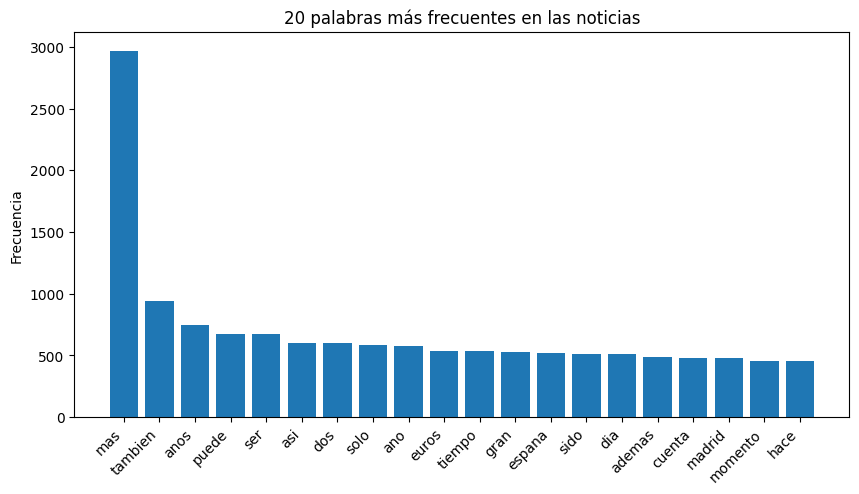

In [9]:
# Grafico de frecuencia de palabras
# Gráfico de las 20 palabras más frecuentes
plt.figure(figsize=(10,5))
plt.bar(freq_df['word'].head(20), freq_df['freq'].head(20))
plt.xticks(rotation=45, ha='right')
plt.title("20 palabras más frecuentes en las noticias")
plt.ylabel("Frecuencia")
plt.show()

Como se mencionó, la palabra "mas" destaca por su alto número de apariciones (2970) a lo largo del conjunto de noticias. Todas las demás frecuencias de palabras se encuentran en un rango similar (500-1000). Por otro lado, a medida que la frecuencia de la palabra disminuye, la palabra suele hacerse más larga, por ejemplo: tiempo, españa, ademas y momento. De estas 20 palabras, la mayoría se puede clasificar en 3 grupos, algunas son adverbios (más, también, así, solo, además y hace), otras formas verbales de verbos comunes: puede (poder), ser y sido (ser) y otras palabras relacionadas con el tiempo o una cantidad: anos (palabra transformada años), dos, euros, tiempo, dia, cuenta y momento.

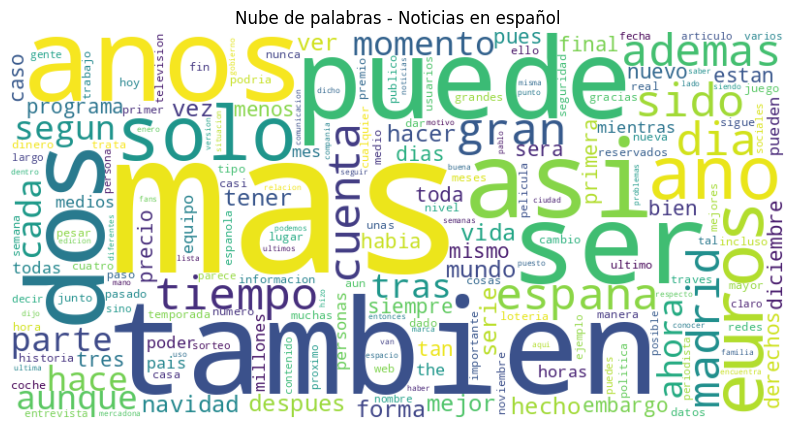

In [10]:
# Visualización de frecuencias (Nube de palabras)
# Generar la nube
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(freq_df.set_index('word')['freq'])

# Mostrar la nube
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Noticias en español")
plt.show()

Otra forma de identificar la frecuencia de las palabras es mediante una nube de palabras, donde la palabra es más grande cuanto mayor es su frecuencia. En este caso, podemos observar un mayor número de palabras a comparación del gráfico de barras anterior. Algunas palabras que también son comunes (tamaño relativamente grande) y no visualizamos antes son: cada, ahora, navidad, según, parte, programa, etc.

## Matriz de presencia de término por documento

In [11]:
# Cuántos noticias contienen cada palabra
doc_freq = np.sum(X > 0, axis=0).A1  # .A1 convierte a array plano
doc_percentage = 100 * doc_freq / X.shape[0]

df_docfreq = pd.DataFrame({
    "word": terms,
    "n_docs": doc_freq,
    "pct_docs": doc_percentage
}).sort_values(by="pct_docs", ascending=False)

df_docfreq


,word,n_docs,pct_docs
1038,mas,712,83.764706
1674,tambien,473,55.647059
1596,ser,367,43.176471
144,asi,353,41.529412
97,anos,350,41.176471
...,...,...,...
1841,york,17,2.000000
1839,width,17,2.000000
1843,zaragoza,17,2.000000
0,abierta,17,2.000000


Aquí, nuevamente aparecen las palabras más y menos frecuentes teniendo en cuenta las 850 noticias. Esta vez, no nos centramos en el número de veces que aparecen, sino en cuantos documentos distintos (n_docs). Vemos que palabras como "mas", "tambien", "ser" y "asi" tienen una alta frecuencia, y a la vez, aparecen en un elevado número de noticias distintas. También, podemos ver que el filtro de max_df y min_df que aplicamos al dataset se cumple, siendo el mayor porcentaje (83.76%) y el menor (2%).

In [12]:
# Cantidad de palabras que aparece en cada noticia y sus porcentajes
freq_table = pd.Series(doc_freq).value_counts().reset_index()
freq_table.columns = ['Num_Noticia', 'Num_Palabras']
# Ordena el DataFrame por la cantidad de noticia
freq_table = freq_table.sort_values(by='Num_Noticia')
freq_table['Porcentaje_aparicion'] = (
    freq_table['Num_Palabras'] / freq_table['Num_Palabras'].sum() * 100
).round(2)

# Muestra el resultado
freq_table

,Num_Noticia,Num_Palabras,Porcentaje_aparicion
0,17,118,6.39
1,18,110,5.96
3,19,89,4.82
2,20,97,5.25
4,21,74,4.01
...,...,...,...
116,350,1,0.05
115,353,1,0.05
158,367,1,0.05
167,473,1,0.05


En la tabla de arriba se ven 3 columnas: Num_Noticia, Num_Palabras y Porcentaje_aparición. A partir de estas podemos saber cuantas palabras aparecen en cierto número de noticias. Además, el % de palabras únicas que aparecen en cada distinto número de noticias. Así, se puede decir que unas 118 palabras (que representan un 6,39% de las palabras únicas) aparecen en 17 noticias distintas y solo 1 palabra ("mas", que representa un 0.05% de las palabras únicas) aparece en 712 noticias diferentes. Es evidente que un mayor número de palabras únicas está presente solo en algunas noticias y un menor número de palabras únicas en varias (palabras muy comunes).

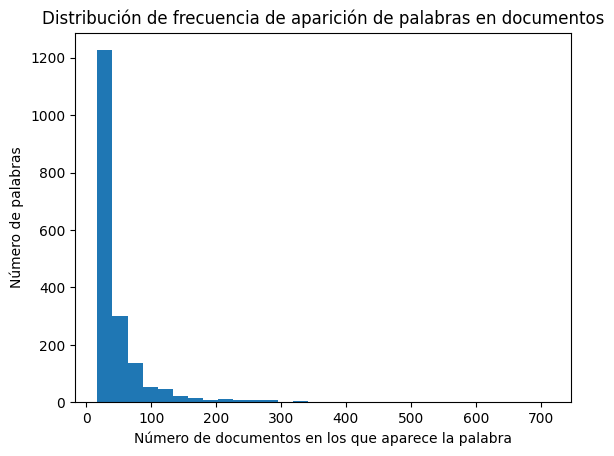

In [13]:
plt.hist(doc_freq, bins=30)
plt.title("Distribución de frecuencia de aparición de palabras en documentos")
plt.xlabel("Número de documentos en los que aparece la palabra")
plt.ylabel("Número de palabras")
plt.show()

Siguiendo con lo anterior, usando las columnas Num_Noticia y Num_Palabras para realizar un histograma, se evidencia que la distribución es asimétrica positiva (varias palabras aparecen en pocos documentos y pocas palabras aparecen en muchos de estos).

## Asociaciones de palabras y graficos de correlacion

In [14]:
freq_threshold = 100  # aparece en más de 100 artículos, filtrar palabras muy poco frecuentes para acelerar el cálculo
dtm_filtrada = dt_matrix.loc[:, dt_matrix.sum(axis=0) > freq_threshold]

# Calcular matriz de correlación
c = dtm_filtrada.corr()

# Eliminar correlaciones débiles (<0.2)
corThreshold = 0.2
c[c < corThreshold] = 0

# Limpiar valores nulos y diagonales
c = np.nan_to_num(c)
np.fill_diagonal(c, 0)

# Ejemplo
palabra = "gobierno"
correlaciones = dtm_filtrada.corrwith(dtm_filtrada[palabra]).sort_values(ascending=False)
correlaciones.head(10)

,0
gobierno,1.000000
sanchez,0.478505
publico,0.229081
falta,0.194526
articulo,0.187248
acuerdo,0.180091
final,0.166504
explica,0.165659
tras,0.162883
medida,0.162291


Otro análisis interesante para aplicar a los términos es la asociación de palabras. Para ello, y con tal conseguir un cálculo más rápido seleccionamos solo los térmnios que aparecen en más de 100 noticias. Además, nos intereso ver las relaciones fuertes y por tanto eliminamos los valores de correlación menores a 0.2.

Luego, probamos la asociación de palabras con el término gobierno. La primera palabra es ella misma, como es esperable con una correlación de 1. Después, la correlación que se observa para cada una de las demás palabras no supera el valor de 0.5, aunque el término sanchez está bastante cerca. Esto tiene bastante sentido ya que Pedro Sánchez es el actual presidente de Gobierno de España y por tanto es normal que ambas palabras sean mencionadas juntas.

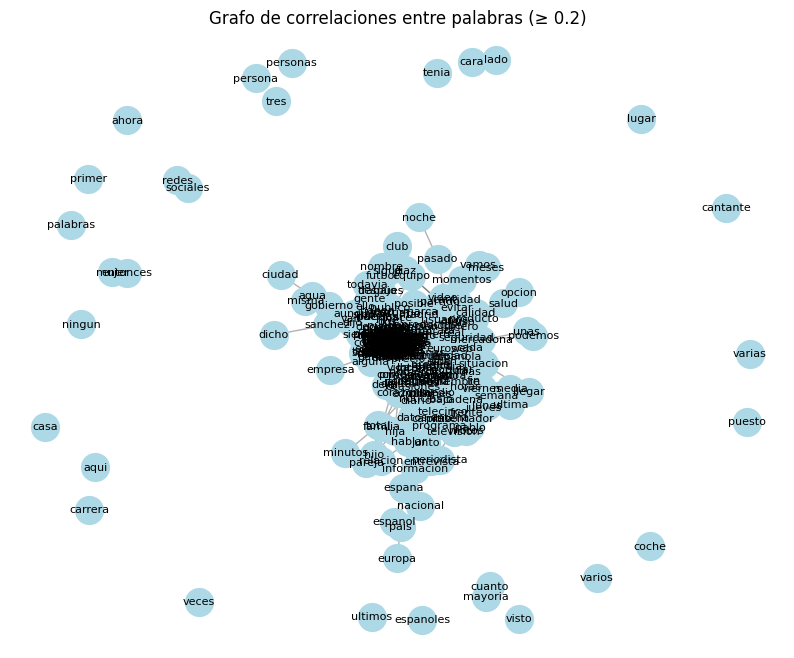

In [15]:
# Crear grafo no dirigido ponderado
G = nx.Graph(c)

# Etiquetas = nombres de las palabras
labels = {i: col for i, col in enumerate(dtm_filtrada.columns)}

# Dibujo del grafo
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.title("Grafo de correlaciones entre palabras (≥ 0.2)")
plt.axis("off")
plt.show()

Con este gráfico podemos ver las correlaciones entre las distinas palabras, es más general que lo anterior y una menor distancia indica mayor correlación. Se ve un gran cúmulo de palabras al centro, algunas tan cercanas que el texto se solapa. Además, hay algunas palabras más alejadas que forman un círculo alrededor. Algunas correlaciones altas son: (redes, sociales), (español, pais) y (pareja, hijo). En el primer par ambas palabras tienen su propio siginificado por separado, pero juntas se refieren a un concepto muy mencionado: las redes sociales. El segundo par hace referencia al idioma o ciudadano de un país y el tercer par relaciona a 2 seres queridos.

# Analisis cuantitativo de texto

In [16]:
# Longitud de palabras y número de palabras por noticia
# Número de palabras por noticia (después del preprocesado)
# Convierte el DataFrame dtm en una matriz
dtm_matrix = dt_matrix.values
# Obtiene los nombres de las columnas
column_names = dt_matrix.columns

# Filtra los nombres de las columnas para mantener solo aquellos con longitud menor a 20 caracteres (por errores en la lematización hay algunas palabras muy largas)
words = [name for name in column_names if len(name) < 20]

# Calcula las longitudes de las palabras y crea un DataFrame
word_lengths = pd.DataFrame({'Word': words, 'Length': [len(word) for word in words]})
# Obtén un resumen estadístico de las longitudes
summary = word_lengths['Length'].describe()
summary

,Length
count,1844.000000
mean,6.969631
std,2.235498
min,3.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,15.000000


Obtenemos 1844 palabras únicas luego de realizar el filtrado de solo seleccionar aquella con longitud menor a 20 caracteres. Este filtrado se aplico ya que la lematización produjo palabras muy largas erróneas. La longitud mínima es de 3 caracteres, la máxima de 15 y la media tiene un valor de 7 aproximadamente. Es decir, a pesar del filtrado, la longitud de las palabras tiene una distribución asimétrica hacia la derecha.

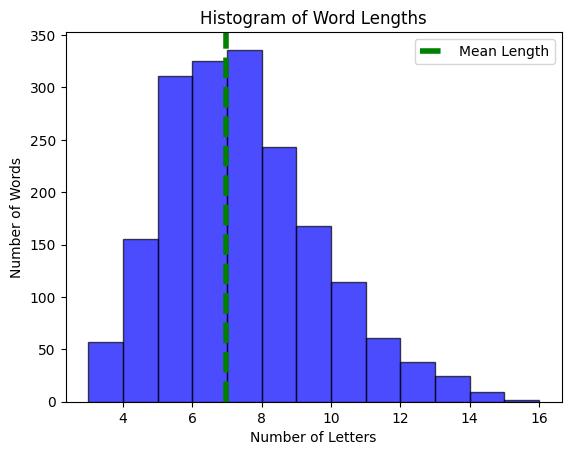

In [17]:
# Calcula la longitud de cada palabra en la lista
nletters = [len(word) for word in words]

# Crea un histograma de las longitudes de las palabras
plt.hist(nletters, bins=range(min(nletters), max(nletters) + 2), alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=sum(nletters) / len(nletters), color='green', linestyle='--', linewidth=4)

# Configura etiquetas y título
plt.xlabel('Number of Letters')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Lengths')
plt.legend(['Mean Length'])

plt.show()

Aquí podemos ver mucho mejor la distribución del número de letras de las palabras. Vemos que hay asimetría aunque no es muy pronunciada. Las frecuencias más altas son las palabras de entre 5-8 letras. Las palabras dentro de este rango (Q1 - Q3) equivalen al 50% del total.

In [18]:
# Frecuencia de letras
texto_total = " ".join(df["clean_text"])
words = texto_total.split()
# Divide las palabras en caracteres individuales
word_chars = [list(word) for word in words]

# Une todos los caracteres en una lista plana
flat_chars = [char for sublist in word_chars for char in sublist]
# Esto elimina números, guiones, barras bajas, símbolos y emojis, dejando solo letras válidas
# flat_chars = [char.lower() for sublist in word_chars for char in sublist if re.match(r'[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]', char)]

# Crea una tabla de frecuencia de las letras
dist_tab = pd.Series(flat_chars).value_counts().reset_index()
dist_tab.columns = ['Letter', 'Freq']

# Convierte la columna 'Letter' a mayúsculas y crea un factor
dist_tab['Letter'] = dist_tab['Letter'].str.upper()
dist_tab['Letter'] = pd.Categorical(dist_tab['Letter'],
                                    categories=dist_tab['Letter'].value_counts().index)

# Calcula la proporción de cada letra
dist_tab['Percent'] = dist_tab['Freq'] / dist_tab['Freq'].sum() * 100
dist_tab[:5]


print(dist_tab['Letter'])


0     A
1     E
2     O
3     I
4     R
5     S
6     N
7     T
8     C
9     D
10    L
11    M
12    U
13    P
14    B
15    G
16    V
17    F
18    H
19    J
20    Z
21    Y
22    Q
23    X
24    K
25    W
26    _
27    3
28    C
Name: Letter, dtype: category
Categories (28, object): ['C', 'A', 'O', 'E', ..., 'K', 'W', '_', '3']


Al momento de mostrar la columna de las letras, vemos que hay 28 filas. A parte de las letras del abecedario aparecen caracteres como: 3 y _. Esto se puede deber a que hay palabras como covid_19 o 3D, y las están contando como letras. Si no se quisiera que aparezcan, se puede usar la alternativa de flat_chars.

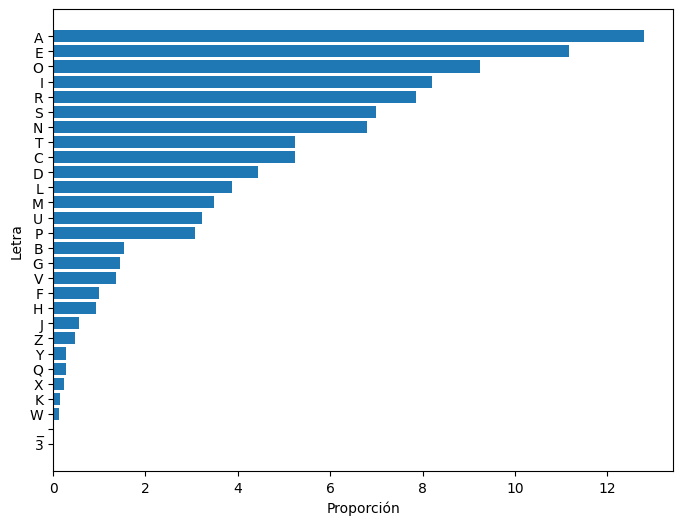

In [19]:
# Crea un gráfico de barras
plt.figure(figsize=(8, 6))
plt.barh(dist_tab['Letter'], dist_tab['Percent'])
plt.xlabel('Proporción')
plt.ylabel('Letra')
plt.gca().invert_yaxis()  # Invierte el eje y para que las letras se muestren en orden descendente
plt.show()

Podemos ver para cada letra, su proporción teniendo en cuenta todos los caracteres de las 850 noticias. Dominan las vocales: A, E, O e I. Esto es razonable, y demuestra que los textos de las noticias están escritos en español. Por el contrario, las letras que menos aparecen son las finales del abecedario como: Z, Y, Q, X y W. Estas están más presentes en otros idiomas como: inglés o francés.

In [20]:
# Riqueza lexica, variedad de vocabulario
df['riqueza_lexica'] = df['clean_text'].apply(lambda x: len(set(x.split())) / len(x.split()))
df['riqueza_lexica'].describe()

,riqueza_lexica
count,850.000000
mean,0.734218
std,0.130328
min,0.075395
25%,0.699487
50%,0.760915
75%,0.812601
max,0.961039


En cuanto a la riqueza léxica, la definimos como: número de palabras únicas/número total de palabras para cada noticia. En general, la media de riqueza léxica es bastante alta (73.42%). Esto quiere decir que, en su mayoría, hay variedad de palabras en la noticia. El valor mínimo para una noticia es 7.54%,  cuenta con palabras repetidas y probablemente es clickbait.

# Cluster de similaridad

## Cluster de terminos

In [21]:
# Elegimos la DTM filtrada y un subconjunto de términos (para que el gráfico sea legible)
DTM = dtm_filtrada

min_total = 150   # frecuencia total mínima del término en el corpus
max_terms = 60     # máximo nº de términos a mostrar en el dendrograma

DTM_sub = DTM.loc[:, (DTM.sum(axis=0) >= min_total)]

top = DTM_sub.sum(axis=0).sort_values(ascending=False).head(max_terms).index
DTM_sub = DTM_sub.loc[:, top]

DTM_sub

# Para hacer el clustering por términos, debemos tenerlos en las filas, no las columnas, y extraer solo los valores en una matriz, no un data frame
X_terms = DTM_sub.T.values   # filas= términos, columnas= documentos
labels  = DTM_sub.columns    # nombres de los términos, lo guardamos para el gráfico

X_terms

array([[1, 1, 1, ..., 3, 0, 9],
       [2, 1, 1, ..., 1, 0, 3],
       [1, 3, 0, ..., 4, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 7]])

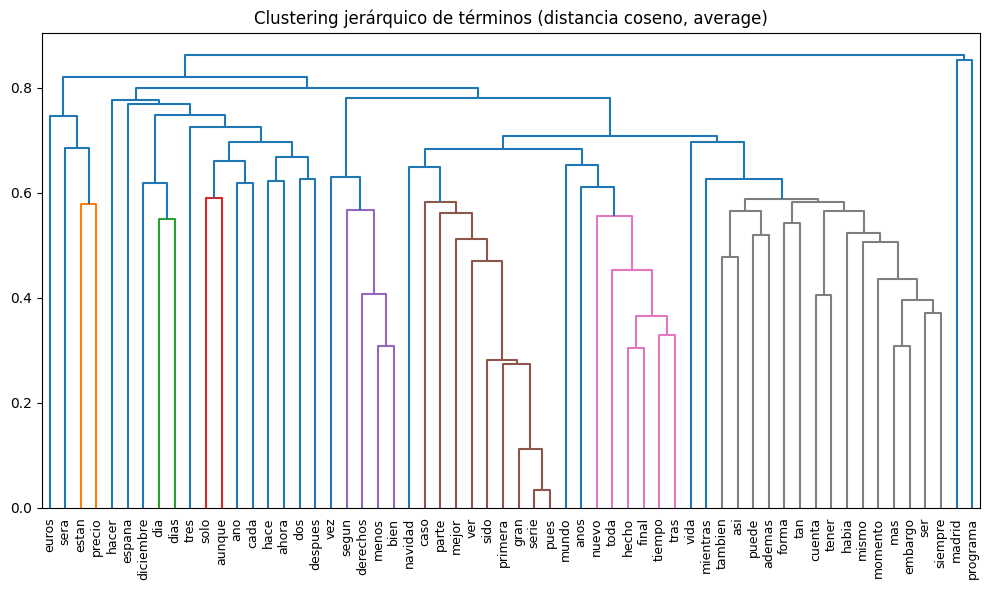

In [22]:
D = pdist(X_terms, metric='cosine')   # Usamos como distancia 1 - similitud de coseno (existen muchas otras opciones)
Z = linkage(D, method='average')      # Usamos un linkage o enlace average, habitual con la distancia del coseno

# Realizamos el gráfico con el dendograma, el gráfico que visualiza clusters jerárquicos
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=9, color_threshold=None)
plt.title("Clustering jerárquico de términos (distancia coseno, average)")
plt.tight_layout()
plt.show()

Para realizar el dendrograma, hemos usado como métrica la distancia del coseno y como método de enlace: average. Se observan 8 colores distintos en el dendrograma. Teniendo en cuenta algunos grupos de palabras que se unen a menos de una distancia de 0.8, podemos decir que: (euros, estan, sera, precio) es un grupo centrado en términos de valor, la moneda euro, y su estado presente y futuro, (diciembre, dia, tres) combina terminos temporales, donde el tres probablemente se escribe como parte de una fecha y (mejor, gran, primera, parte) son términos comparativos.

## Cluster por noticias

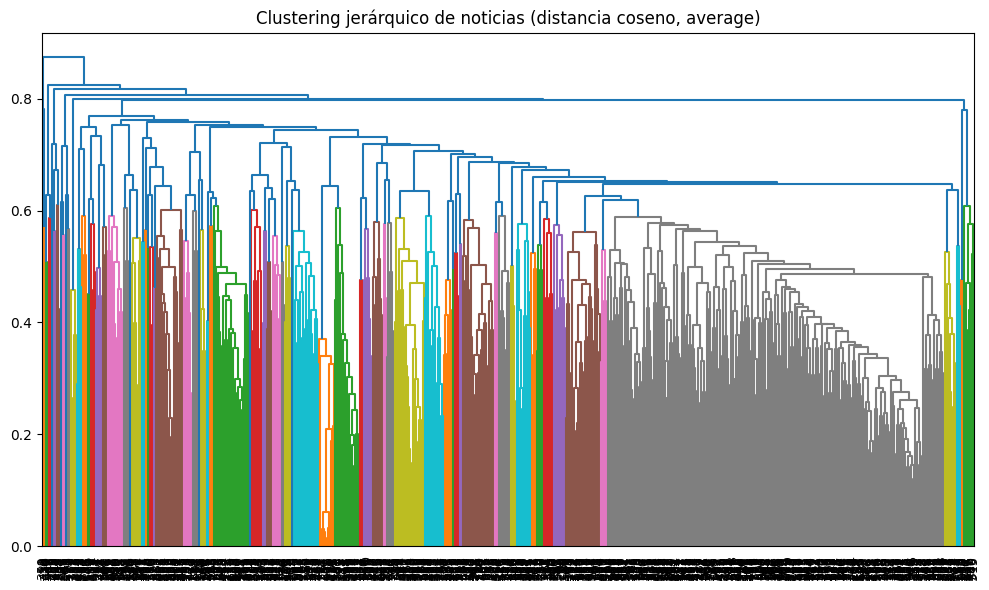

In [23]:
# En este caso queremos los documentos en las filas, y los términos en las columnas
X_terms_docs = DTM_sub.values

# Remove rows with all zeros to avoid issues with cosine distance
X_terms_docs = X_terms_docs[~np.all(X_terms_docs == 0, axis=1)]

D = pdist(X_terms_docs, metric='cosine')
Z = linkage(D, method='average')

plt.figure(figsize=(10, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=9, color_threshold=None)
plt.title("Clustering jerárquico de noticias (distancia coseno, average)")
plt.tight_layout()
plt.show()

El clustering para noticias es enorme. Se distingue una gran cantidad de colores, hay tantos valores en el eje X que no se puede distinguir cada uno. Debido a ello decidimos hacer un filtrado (eliminando noticias vacías, un texto que, después de aplicar CountVectorizer y sus filtros (max_df, min_df), no contiene ninguna de las palabras; y estableciendo un treshold = 0.7).

Número de noticias por cluster:
29    461
27     45
20     39
24     37
17     33
23     31
21     29
26     20
14     17
18     14
13     14
25     12
12     11
28     10
31     10
11      7
19      7
4       7
8       6
3       6
10      6
6       5
7       4
9       4
15      3
22      3
1       2
16      2
30      2
5       1
2       1
Name: count, dtype: int64

Cluster 1 (n=2)
Ejemplos de noticias:
['alberto chicote junto equipo programa lasexta vas comer instalaciones fabrica productos supuestamente artesanos pedir explicaciones chef habia probado unas galletas empanada tarta podido comprobar realmente artesanales prometia empresa trabajadores habian asegurado equipo productos artesanales embargo pudieron comprobar contenian conservantes ingredientes delataba equipo llego poligono encontraba fabrica rapidamente invitaron chicote entrar conocemos television decia trabajadores embargo buenas caras esfumaron pronto chicote decidio directo grano pregunta artesanal responsables tratar

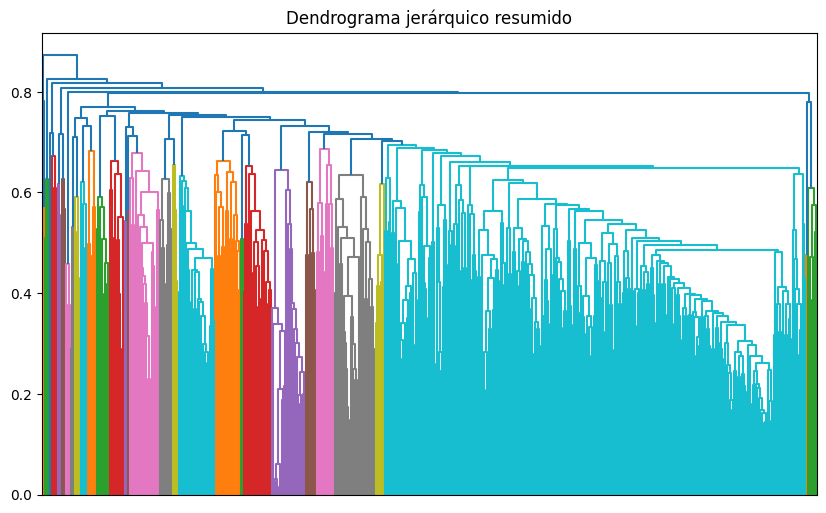

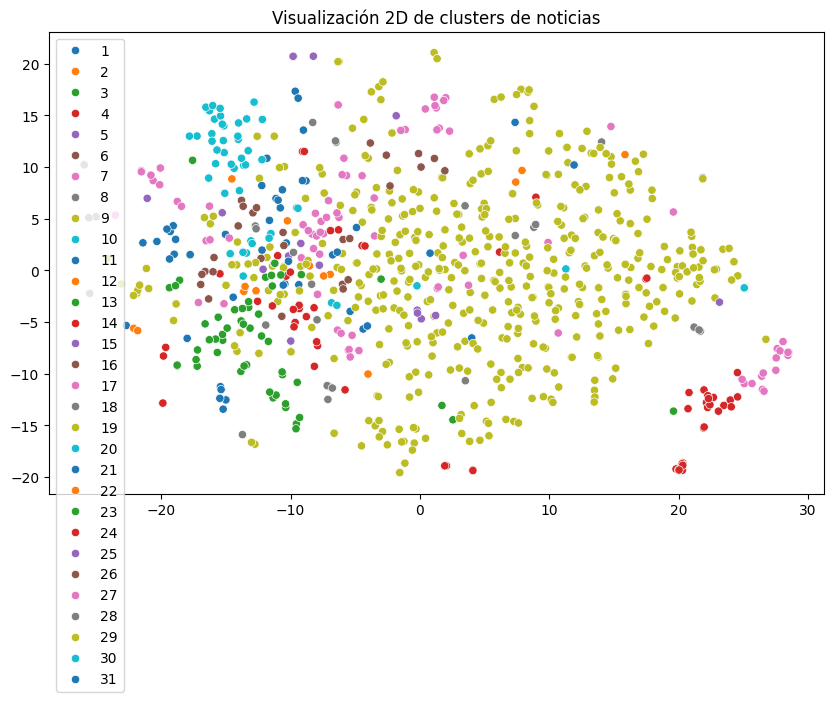

In [24]:
# Select the rows from df that correspond to the non-zero rows in X_terms_docs
df_filtered = df[~np.all(DTM_sub.values == 0, axis=1)].copy()

# Filter dtm_filtrada based on the same rows
dtm_filtrada = dtm_filtrada.loc[df_filtered.index, :].copy()

# Cortar dendrograma para asignar clusters
treshold = 0.7  # Ajusta según cuántos clusters quieras
clusters = fcluster(Z, t=treshold, criterion='distance')

# Add cluster assignments to both dataframes
dtm_filtrada['cluster'] = clusters
df_filtered['cluster'] = clusters


# Resumen de clusters
print("Número de noticias por cluster:")
print(pd.Series(clusters).value_counts())

for c in sorted(dtm_filtrada['cluster'].unique()):
    print(f"\nCluster {c} (n={sum(dtm_filtrada['cluster']==c)})")
    print("Ejemplos de noticias:")
    print(df_filtered[df_filtered['cluster']==c]['clean_text'].head(3).tolist())

# Opcional: dendrograma resumido mostrando solo cluster principales
plt.figure(figsize=(10,6))
dendrogram(Z, no_labels=True, color_threshold=treshold)
plt.title("Dendrograma jerárquico resumido")
plt.show()

# t-SNE para visualización 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_terms_docs)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=clusters, palette='tab10', legend='full')
plt.title("Visualización 2D de clusters de noticias")
plt.show()

Primero, se observa cuantas noticias componen cada cluster. El cluster número 29 (de color celeste en el dendrograma) se destaca con 461 noticias (más del 50%). El segundo cluster más grande es mucho más pequeño contiene 45 noticias (5.3%). Viendo los títulos de las noticias del cluster 29 se deduce que la temática del cluster es de tecnología, programación e IA. También, existen ciertos grupos bastante separados de los demás, contienen pocas noticias (ejem: 4) y no llegaron a juntarse antes de la distancia establecida (0.7). Un cluster pequeño es el cluster 30 con 2 documentos, ahí la temática es noticias de cultura viral, anécdotas y redes sociales.

Además, para una mejor visualización,tras determinar y aislar el número final de clusters, se emplea una técnica de reducción de la dimensionalidad TSNE en 2 dimensiones. Así, podemos ver cada observación/noticia con su color correspondiente (cluster al que pertenece) y las distancias entre estas en un plano. Si bien existen colores dispersos, lo cual es normal en datos de texto de alta dimensionalidad, las agrupaciones principales muestran una clara estructura temática.

# Análisis de clasificación Temática

In [25]:
# --- 1. PREPARACIÓN DE DATOS ADAPTADA ---

# La 'X' de entrada es el texto preprocesado.
X = df_filtered["clean_text"]
# La 'y' de salida es la etiqueta de Cluster (la convertimos a string si es necesario).
y = df_filtered["cluster"].astype(str)

# --- 2. DIVISIÓN DE DATOS ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --- 3. CREACIÓN Y ENTRENAMIENTO del Pipeline ---

clf = make_pipeline(
    TfidfVectorizer(strip_accents="unicode", lowercase=True, ngram_range=(1,2), min_df=1),
    LinearSVC(random_state=42)
)

print("Entrenando clasificador...")
clf.fit(X_train, y_train)

# --- 4. EVALUACIÓN DEL MODELO ---
y_pred = clf.predict(X_test)

print("\n" + "="*50)
print("INFORME DE CLASIFICACIÓN TEMÁTICA (Clusters)")
print("="*50)
# Esto evalúa qué tan bien el modelo predice la categoría temática (cluster) de una noticia.
print(classification_report(y_test, y_pred))

# --- 5. EXTRACCIÓN DE RASGOS (Términos Clave por Cluster) ---
# Se adapta la extracción de rasgos para ver qué términos son más importantes para cada uno de tus clusters temáticos.

vec = clf.named_steps["tfidfvectorizer"]
svc = clf.named_steps["linearsvc"]
feats = vec.get_feature_names_out()

print("\n" + "="*50)
print("TOP RASGOS CARACTERÍSTICOS POR CLUSTER")
print("="*50)

# Iterar sobre las clases (clusters) predichas
for i, cluster_label in enumerate(svc.classes_):
    # El coeficiente para el cluster 'cluster_label'
    coefs = svc.coef_[i]

    # Ordenar los coeficientes para encontrar los rasgos más predictivos (positivos)
    # del cluster específico (los que más "empujan" una noticia a ser clasificada como Cluster X)
    top_terms = pd.Series(coefs, index=feats).sort_values(ascending=False).head(10)

    print(f"\nCluster {cluster_label} (Top 10 Rasgos Típicos):")
    # Los términos con coeficientes más altos son los más distintivos de ese cluster.
    print(top_terms)

Entrenando clasificador...

INFORME DE CLASIFICACIÓN TEMÁTICA (Clusters)
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         1
          17       1.00      0.14      0.25         7
          18       0.00      0.00      0.00         3
          19       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         1
          20       1.00      0.30      0.46        10
          21       0.00      0.00      0.00         9
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00        13
          24       1.00      0.40      0.57        15
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



TOP RASGOS CARACTERÍSTICOS POR CLUSTER

Cluster 10 (Top 10 Rasgos Típicos):
gallegos         0.391876
prefijo          0.383540
espanoles        0.314327
kamiya           0.310129
xiaomi           0.302234
piensan          0.300311
juegos           0.263137
platinumgames    0.247784
hideki kamiya    0.247784
hideki           0.247784
dtype: float64

Cluster 11 (Top 10 Rasgos Típicos):
cartel       0.350212
jugador      0.291201
dias         0.242470
sentencia    0.213106
buenos       0.210229
falso        0.203704
mercadona    0.202055
club         0.185278
fifa         0.174592
despido      0.174414
dtype: float64

Cluster 12 (Top 10 Rasgos Típicos):
sarten               0.506608
uva                  0.449417
declaracion          0.392424
caso                 0.364493
tuvalu               0.355254
alcoholemia          0.309986
declaracion anual    0.291101
oscar                0.273864
esther               0.266686
canales              0.264701
dtype: float64

Cluster 13 (Top 10 Rasg

Una vez que el proceso de clustering jerárquico definió las categorías temáticas de las noticias, el objetivo siguiente fue construir un modelo de Clasificación Supervisada para automatizar la asignación de noticias nuevas a estos clusters. Para lograrlo, se implementó un pipeline que combina la transformación de texto y el algoritmo de clasificación.

Además, para cada cluster se ha realizado la clasificación mediante 3 métricas: precision, recall y f1-score, y para ver la calidad de clasificación general usamos otras métricas como: accuracy, macro average y weighted average. Dentro del informe de clasificación temática (clusters) se ve que, a parte de las métricas, cada cluster cuenta con un valor en support (número real de observaciones de ese cluster en los datos de test).

Los clusters con mayor support son: el cluster 29 (135), cluster 24 (15), cluster 23 (13) y cluster 27 (12). Coincidentemente, la mayoría de estos clusters  obtienen los valores más elevados en las 3 métricas en comparación a las demás clases. Esto se debe a que las clases/clusters están desbalanceadas.

Al analizar las métricas generales, podemos decir que el 59% de los textos fueron clasificados en el cluster correcto (accuracy). macro_avg f1: el valor de 0.12 es muy bajo, solo algunas clases se predicen bien. weighted_avg f1: es más alto que la métrica anterior, pero está sesgado por las clases de mayor valor de support.

En conclusión, el modelo aprende a clasificar bien clusters con un alto número de noticias, pero falla en los clusters minoritarios (donde se observan valores de 0 en las 3 métricas).

Por otro lado, se obtuvieron los términos típicos de cada cluster, mediante estos podemos deducir la temática de cada uno. Algunos ejemplos son: cluster 19 (noticias de automoción), cluster 20 (noticias de Madrid) y cluster 21 (cultura, entretenimiento y personajes públicos españoles).

# Análisis Descriptivo por Fuente (web_url)

In [26]:
# Función para extraer el dominio principal de una URL
def extract_domain(url):
    try:
        # Usa urlparse para descomponer la URL
        domain = urlparse(url).netloc
        # Eliminar 'www.' si existe y asegurarse de que solo se queda el dominio principal
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'UNKNOWN'

# Creamos la nueva columna 'source'
df_filtered['source'] = df_filtered['web_url'].apply(extract_domain)

# Contar cuántas noticias tienes por fuente para ver los medios principales
print("Top 10 Medios de Comunicación en el Dataset:")
print(df_filtered['source'].value_counts().head(10))

Top 10 Medios de Comunicación en el Dataset:
source
huffingtonpost.es                 156
okdiario.com                       61
cope.es                            56
cadenaser.com                      39
ow.ly                              35
mundodeportivo.com                 33
buff.ly                            21
lectur.as                          20
eltelevisero.huffingtonpost.es     18
bit.ly                             17
Name: count, dtype: int64


Vemos que los 5 medios con mayor número de noticias abarcan el 40,82% de estas. Estos medios son: huffingtonpost.es, okdiario.com, cope.es, cadenaser.com y ow.ly

## Longitud Media del Texto: ¿Las noticias de un medio son sistemáticamente más largas o más cortas?

In [27]:
# Calcula la longitud del texto (web_text)
df_filtered['text_length'] = df_filtered['web_text'].apply(len)
# Compara la media por fuente
print("\nLongitud Media del Texto por Fuente (Top 5):")
print(df_filtered.groupby('source')['text_length'].mean().sort_values(ascending=False).head(5))


Longitud Media del Texto por Fuente (Top 5):
source
alfabetajuega.com            29007.2
elpais.com                   10956.0
lawebdelinformatico.es        8607.0
nationalgeographic.com.es     8525.0
cnn.it                        7008.5
Name: text_length, dtype: float64


Se observa que, con gran diferencia, la fuente alfabetajuega.com suele redactar noticias más largas que los demás medios. Alfabetajuega.com se centra en videojuegos y cultura digital. Es decir, su temática es especializada y con una redacción detallada.  

## Distribución de Clusters: ¿Ciertos medios se enfocan más en temas específicos?

In [32]:
# Tabla de contingencia de Cluster vs. Fuente, con las primeras 20 fuentes
cluster_source_pivot = pd.crosstab(df_filtered['cluster'], df_filtered['source'], normalize='columns')
print("\nDistribución de Clusters por Fuente")
print(cluster_source_pivot.head(31).iloc[:, :20])


Distribución de Clusters por Fuente
source   20minutos.es  3djuegos.com  abc.com.py  adslzone.net  \
cluster                                                         
1                 0.0      0.000000         0.0      0.000000   
2                 0.0      0.000000         0.0      0.000000   
3                 0.0      0.000000         0.0      0.000000   
4                 0.0      0.000000         0.0      0.000000   
5                 0.0      0.000000         0.0      0.000000   
6                 0.0      0.000000         0.0      0.000000   
7                 0.0      0.000000         0.0      0.000000   
8                 0.0      0.000000         0.0      0.000000   
9                 0.0      0.000000         0.0      0.000000   
10                0.0      0.000000         0.0      0.000000   
11                0.0      0.000000         0.0      0.000000   
12                0.0      0.000000         0.0      0.111111   
13                0.0      0.000000         0.0      

Arriba podemos leer la proporción de artículos de cada medio que pertenecen a cada cluster. A partir de ello, vemos que hay fuentes cuyos artículos se distribuyen en un reducido número de clusters: 3djuegos.com: cluster 18 (66,7% de noticias) y el resto en el cluster 29 (33,3% de noticias); bitly.ws: cluster 25 (100%)

Por otro lado, hay ditribuciones más variadas: adslzone.net: cluster 12(11%), cluster 18 (22%), cluster 19 (11%), etc.

En otras palabras, gracias a este análisis podemos identificar qué medios contienen noticias de distintas temáticas (proporciones en distintos clusters) o cuales son especializados (noticias pertenecientes a pocos o 1 cluster).

# Análisis de Sentimiento con Librería Externa
Para el análisis de sentimiento en español sin un corpus etiquetado, la mejor estrategia es usar una librería pre-entrenada para español. La librería sentiment-analysis-spanish (o su versión más moderna pysentimiento) es una excelente opción. pysentimiento suele ofrecer modelos más robustos basados en Transformers (BERT-like) y no solo analiza sentimiento (positivo, negativo, neutral), sino también emociones (alegría, tristeza, etc.).

In [29]:
# Crear el analizador para la tarea de SENTIMIENTO en español
# 'sentiment' etiqueta: POSITIVE, NEGATIVE, NEUTRAL
sentiment_analyzer = create_analyzer(task="sentiment", lang="es")

# Crear el analizador para la tarea de EMOCIÓN en español
emotion_analyzer = create_analyzer(task="emotion", lang="es")


# Aplicar el análisis al texto de la noticia (web_text)
def analyze_text_nlp(text, analyzer_type):
    """Function to apply Sentiment or Emotion analysis and return structured results."""
    if not isinstance(text, str) or not text.strip():
        # Return empty values if the text is not valid
        if analyzer_type == 'sentiment':
            return ['EMPTY', 0.0, 0.0, 0.0]
        elif analyzer_type == 'emotion':
             return ['EMPTY', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
             return []


    try:
        if analyzer_type == 'sentiment':
            analysis = sentiment_analyzer.predict(text)
            return [analysis.output, analysis.probas['POS'], analysis.probas['NEG'], analysis.probas['NEU']]

        elif analyzer_type == 'emotion':
            analysis = emotion_analyzer.predict(text)
            main_emotion = analysis.output
            return [main_emotion, analysis.probas.get('joy', 0.0), analysis.probas.get('sadness', 0.0),
                    analysis.probas.get('anger', 0.0), analysis.probas.get('fear', 0.0),
                    analysis.probas.get('surprise', 0.0), analysis.probas.get('disgust', 0.0), analysis.probas.get('other', 0.0)]
    except Exception as e:
        # In case of an error, return error values
        if analyzer_type == 'sentiment':
            return ['ERROR', 0.0, 0.0, 0.0]
        elif analyzer_type == 'emotion':
             return ['ERROR', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
             return []

# Apply analysis to the news text (web_text)
text_sentiment_results = df_filtered['web_text'].apply(lambda x: analyze_text_nlp(x, 'sentiment'))
text_emotion_results = df_filtered['web_text'].apply(lambda x: analyze_text_nlp(x, 'emotion'))

# Unpack the results into separate columns for news text
df_filtered[['text_sentiment', 'text_prob_pos', 'text_prob_neg', 'text_prob_neu']] = pd.DataFrame(text_sentiment_results.tolist(), index=df_filtered.index)
df_filtered[['text_emotion', 'text_prob_joy', 'text_prob_sad', 'text_prob_anger',
             'text_prob_fear', 'text_prob_surprise', 'text_prob_disgust', 'text_prob_other']] = pd.DataFrame(text_emotion_results.tolist(), index=df_filtered.index)


# Apply analysis to the headline (web_headline)
headline_sentiment_results = df_filtered['web_headline'].apply(lambda x: analyze_text_nlp(x, 'sentiment'))
headline_emotion_results = df_filtered['web_headline'].apply(lambda x: analyze_text_nlp(x, 'emotion'))

# Unpack the results into separate columns for headline
df_filtered[['headline_sentiment', 'headline_prob_pos', 'headline_prob_neg', 'headline_prob_neu']] = pd.DataFrame(headline_sentiment_results.tolist(), index=df_filtered.index)
df_filtered[['headline_emotion', 'headline_prob_joy', 'headline_prob_sad', 'headline_prob_anger',
             'headline_prob_fear', 'headline_prob_surprise', 'headline_prob_disgust', 'headline_prob_other']] = pd.DataFrame(headline_emotion_results.tolist(), index=df_filtered.index)

KeyboardInterrupt: 

In [ ]:
# ANÁLISIS DESCRIPTIVO DE RESULTADOS

print("\n" + "="*70)
print("ANÁLISIS 1: DISTRIBUCIÓN DE SENTIMIENTO Y EMOCIÓN")
print("="*70)

print("\n--- SENTIMIENTO PREDOMINANTE EN EL TITULAR ---")
print(df_filtered['headline_sentiment'].value_counts(normalize=True))

print("\n--- SENTIMIENTO PREDOMINANTE EN EL CUERPO ---")
print(df_filtered['text_sentiment'].value_counts(normalize=True))

print("\n--- EMOCIÓN PREDOMINANTE EN EL TITULAR ---")
print(df_filtered['headline_emotion'].value_counts(normalize=True))


En el caso de los titulares, casi la mitad de estos son neutrales (44,88%), aunque el sentimiento negativo no se queda muy atrás (37,22%). Palabras negativas llaman más la atención que las noticias positivas y por tanto son más usadas en titulares.

 En cuanto al cuerpo de las noticias, sigue siendo más alto la categoría neutral, aunque cabe resaltar que ahora el sentimiento positivo es más alto que el negativo (por un pequeña diferencia). La diferencia puede deberse a noticias clickbait, donde si bien se usa un titular atractivo con palabras negativas, el contenido de este no está alineado.


 Finalmente,las emociones predominantes en los titulares, como joy (alegría), surprise (sorpresa), anger (enojo) y sadness (tristeza), tienen un % muy bajo. Domina la categoría others (93,64%). Esto se da ya que la categoría others engloba la ausencia de emoción y todas las demás emociones, existen diversas, por lo que es razonable que el % más alto se dé a esta categoría.

In [ ]:
# -----------------------------------------------------------------------
print("\n" + "="*70)
print("ANÁLISIS 2: EL EFECTO CLICKBAIT (Comparación Titular vs. Cuerpo)")
print("="*70)

# El clickbait explota la diferencia entre la emoción del titular y la realidad del texto.

# 1. ¿Qué titular es más negativo que el cuerpo? (Falsa alarma o exageración)
df_filtered['diff_negativity'] = df_filtered['headline_prob_neg'] - df_filtered['text_prob_neg']

print("\n--- TOP 5 NOTICIAS CON MAYOR EXAGERACIÓN NEGATIVA EN EL TITULAR ---")
top_exaggeration = df_filtered.sort_values(by='diff_negativity', ascending=False).head(5)
for index, row in top_exaggeration.iterrows():
    print(f"Titular: {row['web_headline']}")
    print(f"Neg. Head: {row['headline_prob_neg']:.2f} | Neg. Text: {row['text_prob_neg']:.2f} | Diff: {row['diff_negativity']:.2f}")

# 2. ¿Qué emociones negativas son más frecuentes en los titulares?
print("\n--- MEDIAS DE PROBABILIDAD DE EMOCIONES NEGATIVAS EN TITULARES ---")
print(df_filtered[['headline_prob_anger', 'headline_prob_fear', 'headline_prob_disgust']].mean().sort_values(ascending=False))

# -----------------------------------------------------------------------
print("\n" + "="*70)
print("ANÁLISIS 3: DIFERENCIAS POR FUENTE DE NOTICIAS")
print("="*70)

# Agrupamos por fuente para ver si hay un "estilo emocional" por medio
source_emotion_analysis = df_filtered.groupby('source').agg(
    Avg_Neg_Head=('headline_prob_neg', 'mean'),
    Avg_Anger_Head=('headline_prob_anger', 'mean'),
    Total_Articles=('web_url', 'count')
).sort_values(by='Avg_Neg_Head', ascending=False)

print("\n--- RANKING DE FUENTES POR NEGATIVIDAD MEDIA EN EL TITULAR ---")
print(source_emotion_analysis.head(5))

# Distribución de la emoción principal del titular por fuente (tabla de contingencia)
source_emotion_pivot = pd.crosstab(df_filtered['headline_emotion'], df_filtered['source'], normalize='columns')
print("\n--- DISTRIBUCIÓN DE EMOCIONES DEL TITULAR POR FUENTE (TOP 3) ---")
print(source_emotion_pivot.head(3).iloc[:, :5])

La mayor diferencia entre titular y cuerpo se da en el caso del siguiente titular: "Se fija en lo que está pasando en los sitios de playa con los turistas y se indigna: da para reflexión." Aquí, hay claramente clickbait, se exagera un hecho cotidiano.

Al ver las medias de probabilidad de emociones negativas en los titulares, vemos que todos los valores son bajos, siendo el más alto el enojo (anger). Es decir, en general los titulares suelen tener muy poca carga emocional negativa explícita.

Al comparar distintas fuentes vemos que se presentan diferencias entre estas. Por ejemplo, periodistadigital.com destaca por su tono emocional (ira), mientras que público.es y elmundo.es tienen una alta negatividad (tono serio, sin emociones).

Por último, para 5 fuentes, podemos ver la distribución de sus emociones. 4 de estas tienen sus noticias contenidas en una sola categoría (others), donde es posible que halla ausencia de emoción. Sin embargo, 3djuegos.com destaca por un alto % de alegría (joy) con un 33%. Esto indica que fuentes informativas (de contenido general) mantienen un tono neutral. Por el contrario, fuentes especializadas y de entreteniemto (videojuego y cultura gamer) sí muestran emociones.


# Exportación del notebook


In [ ]:
# Celda para compilar el notebook a HTML (descomentar la siguiente línea, hace falta tener instalado nbconvert)
# Una vez creado el HTML, podemos abrirlo en el navegador web y con ctrl+print guardarlo como PDF
# !jupyter nbconvert --to html "2_text_mining.ipynb"